In [1]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
ROTATION_NUMBER=8

CONV_BLOCKS=4
TRANSFER_LAYERS=2

assert TRANSFER_LAYERS<=CONV_BLOCKS


In [3]:
rotations=[i*360/(ROTATION_NUMBER) for i in range(ROTATION_NUMBER)]
rotations

[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

### Transofmations

In [4]:
# -----------------------------------------
class MinMaxScaler:
    def __call__(self, sample):
        return sample / 255


min_transform = transforms.Compose([
    transforms.ToTensor(),
    MinMaxScaler()
])

aug_transform = transforms.Compose([
    transforms.ToTensor(),                                    # Convert to tensor
    MinMaxScaler()
])

## Datasets

In [5]:
X_train = datasets.MNIST(root='./data', train=True, download=True, transform=aug_transform)
X_test = datasets.MNIST(root='./data', train=False, download=True, transform=min_transform)

## Spliting Data

In [6]:
# Extract targets as a NumPy array
targets = np.array(X_train.targets)

# Select 10 indices for each class
indices = []
for digit in range(10):
    digit_indices = np.where(targets == digit)[0][:10]  # Take first 10 samples for each digit
    indices.extend(digit_indices)

X_train_100 = Subset(X_train, indices)

# take 100 

full_unsupervised_set = X_train

In [7]:
train_size = int(0.9 * len(full_unsupervised_set))
val_size = len(full_unsupervised_set) - train_size

unsupervised_train_set, unsupervised_val_set = random_split(full_unsupervised_set, 
                                                            [train_size, val_size])

print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Unsupervised training set: 54000 samples
Unsupervised validation set: 6000 samples


# Rotation dataset

In [8]:
# -----------------------------------------
# 3. Define RotationDataset for Unsupervised Learning
# -----------------------------------------
class RotationDataset(torch.utils.data.Dataset):
    """Dataset that generates rotated versions of images with rotation labels (0°, 90°)."""
    def __init__(self, dataset,rotations):
        self.dataset = dataset
        self.rotations = rotations
        self.rotations_label = {element: index for index, element in enumerate(rotations)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        rotation_angle = random.choice(rotations)
        rotated_image = transforms.functional.rotate(image, rotation_angle)
        rotation_label=self.rotations_label[rotation_angle]

        return rotated_image, rotation_label


## Visulaize

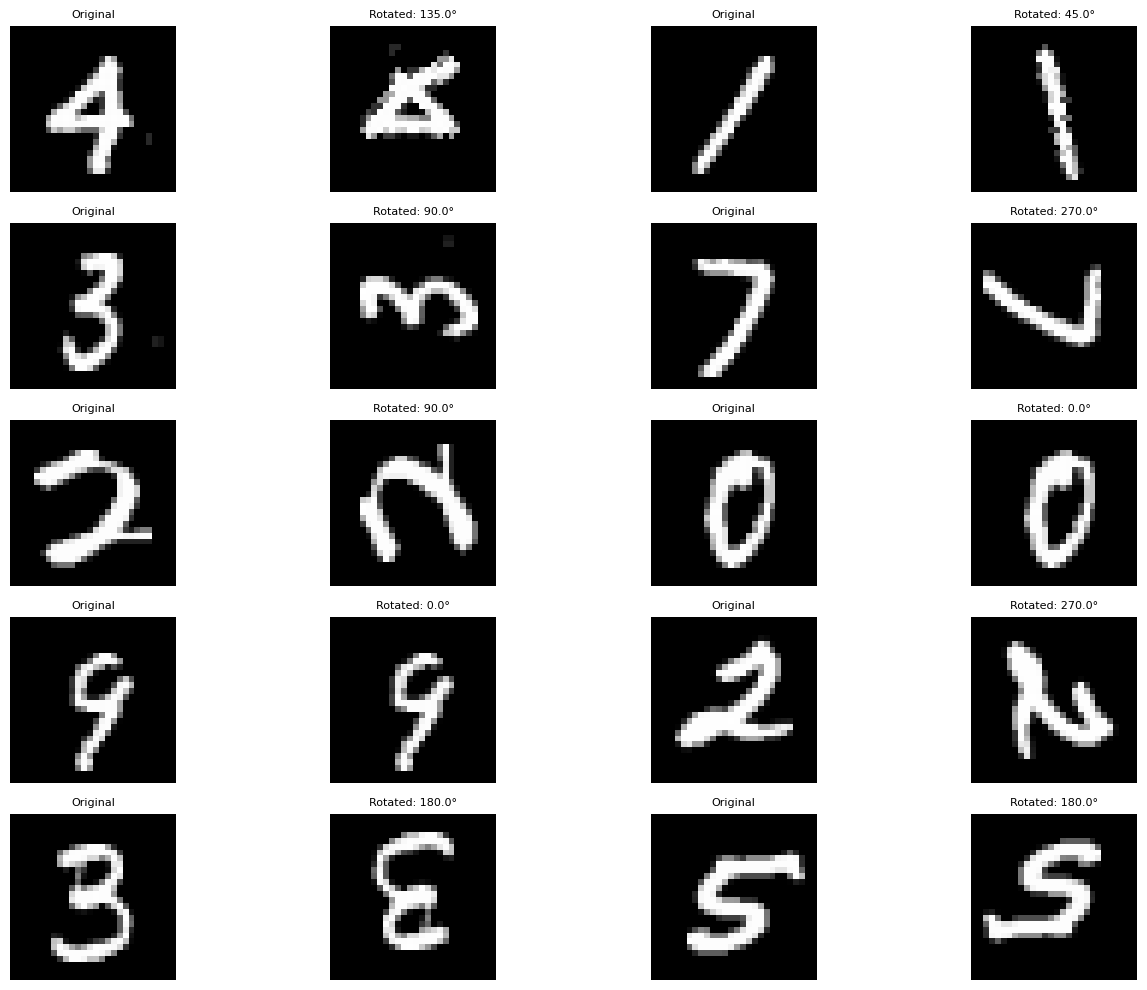

In [9]:
num_images = 10
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

for i in range(num_images):
    idx = torch.randint(0, len(unsupervised_train_set), (1,)).item()
    original_image, _ =unsupervised_train_set[idx]

    rotation_angle = random.choice(rotations)
    rotated_image = transforms.functional.rotate(original_image, rotation_angle)

    original_image = original_image.squeeze(0).numpy()
    rotated_image = rotated_image.squeeze(0).numpy()

    row, col = divmod(i, num_cols)
    original_col = col * 2
    rotated_col = col * 2 + 1

    axes[row, original_col].imshow(original_image, cmap='gray')
    axes[row, original_col].set_title("Original", fontsize=8)
    axes[row, original_col].axis('off')

    axes[row, rotated_col].imshow(rotated_image, cmap='gray')
    axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
    axes[row, rotated_col].axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()



# Defining Model

In [ ]:
# -----------------------------------------
# 4. Define RotNet Model for Rotation Prediction
# -----------------------------------------import torch
class ConvNet(nn.Module):
    """Configurable RotNet model for self-supervised rotation prediction."""
    def __init__(self, input_image_size=28, num_blocks=CONV_BLOCKS, num_classes=8):
        """
        Args:
            input_image_size (int): Size of the input image (assuming square dimensions).
            num_blocks (int): Number of convolutional blocks.
            num_classes (int): Number of output classes (default is 4 for rotation angles).
        """
        super(ConvNet, self).__init__()
        
        self.input_image_size = input_image_size
        self.num_blocks = num_blocks
        self.num_classes = num_classes

        # Initialize convolutional blocks
        in_channels = 1  # Assuming grayscale input
        out_channels = 32

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)  # Reduces the image size by half
                )
            )
            in_channels = out_channels
            out_channels *= 2

        # Adaptive average pooling to reduce to 1x1
        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layer (rotation prediction head)
        self.rotation_head = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        """
        Forward pass of the RotNet model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Tensor: Output logits of shape (batch_size, num_classes).
        """
        for block in self.blocks:
            x = block(x)
        x = self.adaptive_pool(x)  # Output size becomes (batch_size, channels, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.rotation_head(x)
        return x


In [11]:
RotNet()

RotNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), s

In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Initialize TensorBoard
def train_rotnet(model:torch.nn.Module, train_loader, val_loader, criterion, optimizer,learning_rate_scheduler, num_epochs=5,save_path='./model.pth'):
    writer = SummaryWriter(log_dir="runs/rotnet_training")
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
        for step, (images, labels) in enumerate(train_bar):
            images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Log gradients for each parameter
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    writer.add_scalar(f"Gradients/{name}", param.grad.abs().mean().item(), epoch * len(train_loader) + step)

            optimizer.step()
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Log training loss and accuracy to TensorBoard
            writer.add_scalar("Loss/Train", loss.item(), epoch * len(train_loader) + step)
            writer.add_scalar("Accuracy/Train", (correct / total) * 100, epoch * len(train_loader) + step)

            # Update progress bar
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Validation step
        model.eval()
        val_correct = 0
        val_total = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)
        with torch.no_grad():
            for step, (images, labels) in enumerate(val_bar):
                images, labels = images.cuda(), labels.cuda()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Log validation loss to TensorBoard
                writer.add_scalar("Loss/Validation", loss.item(), epoch * len(val_loader) + step)

            val_accuracy = 100 * val_correct / val_total

            if val_accuracy>best_accuracy:
                best_accuracy=val_accuracy
                # save model
                torch.save(model.state_dict(),save_path)


        learning_rate_scheduler.step()

        # Log validation accuracy to TensorBoard
        writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Train Accuracy: {correct/total*100:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
    writer.close()


2024-11-28 14:57:23.833213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 14:57:23.841241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732802243.853305  236712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732802243.857027  236712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 14:57:23.869966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Train rotnet

In [13]:
unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set,
                                                       rotations=rotations), 
                                       batch_size=256,
                                       shuffle=True,
                                       num_workers=8,
                                       persistent_workers=True)

unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set,
                                                     rotations=rotations), 
                                     batch_size=256, 
                                     shuffle=False,
                                     num_workers=8,
                                     persistent_workers=True)




In [ ]:
rotnet = ConvNet(num_classes=len(rotations)).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.00001,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


In [15]:
# Train RotNe
best_model = train_rotnet(rotnet, 
                 unsupervised_train_loader, 
                 unsupervised_val_loader,
                 criterion,
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=20,
                 save_path=f'best_rotnet{rotations}.pth')
best_model=torch.load(f'best_rotnet{rotations}.pth')
    

Epoch 1/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 55.99it/s]


Epoch [1/20], Train Loss: 326.6308, Train Accuracy: 49.54%, Validation Accuracy: 67.80%


Epoch 2/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 93.57it/s]


Epoch [2/20], Train Loss: 199.8882, Train Accuracy: 75.75%, Validation Accuracy: 79.93%


Epoch 3/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 113.48it/s]


Epoch [3/20], Train Loss: 134.0183, Train Accuracy: 85.99%, Validation Accuracy: 86.45%


Epoch 4/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 105.58it/s]


Epoch [4/20], Train Loss: 98.9245, Train Accuracy: 90.60%, Validation Accuracy: 86.57%


Epoch 5/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 105.57it/s]


Epoch [5/20], Train Loss: 78.3210, Train Accuracy: 92.95%, Validation Accuracy: 89.07%


Epoch 6/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 98.92it/s]


Epoch [6/20], Train Loss: 64.9434, Train Accuracy: 94.26%, Validation Accuracy: 89.98%


Epoch 7/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 99.79it/s]


Epoch [7/20], Train Loss: 55.1296, Train Accuracy: 95.22%, Validation Accuracy: 90.18%


Epoch 8/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 94.54it/s]


Epoch [8/20], Train Loss: 47.8726, Train Accuracy: 95.73%, Validation Accuracy: 89.97%


Epoch 9/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 99.02it/s]


Epoch [9/20], Train Loss: 42.1713, Train Accuracy: 96.23%, Validation Accuracy: 90.27%


Epoch 10/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 79.14it/s]


Epoch [10/20], Train Loss: 37.7240, Train Accuracy: 96.62%, Validation Accuracy: 89.68%


Epoch 11/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 100.85it/s]


Epoch [11/20], Train Loss: 34.0093, Train Accuracy: 96.96%, Validation Accuracy: 89.83%


Epoch 12/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 105.52it/s]


Epoch [12/20], Train Loss: 30.9917, Train Accuracy: 97.15%, Validation Accuracy: 89.22%


Epoch 13/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 97.91it/s]


Epoch [13/20], Train Loss: 28.4680, Train Accuracy: 97.38%, Validation Accuracy: 89.15%


Epoch 14/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 104.75it/s]


Epoch [14/20], Train Loss: 26.5890, Train Accuracy: 97.54%, Validation Accuracy: 89.32%


Epoch 15/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 53.01it/s]


Epoch [15/20], Train Loss: 24.6345, Train Accuracy: 97.69%, Validation Accuracy: 89.92%


Epoch 16/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 96.43it/s]


Epoch [16/20], Train Loss: 22.7864, Train Accuracy: 97.87%, Validation Accuracy: 87.30%


Epoch 17/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 98.00it/s]


Epoch [17/20], Train Loss: 21.5233, Train Accuracy: 97.95%, Validation Accuracy: 89.35%


Epoch 18/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 97.89it/s]


Epoch [18/20], Train Loss: 20.3771, Train Accuracy: 98.09%, Validation Accuracy: 90.68%


Epoch 19/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 47.31it/s]


Epoch [19/20], Train Loss: 19.2789, Train Accuracy: 98.12%, Validation Accuracy: 90.82%


Epoch 20/20 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 95.36it/s]

Epoch [20/20], Train Loss: 18.1734, Train Accuracy: 98.26%, Validation Accuracy: 90.28%



/tmp/ipykernel_236712/552086884.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load(f'best_rotnet{rotations}.pth')


### Train Baseline

In [16]:
supervised_train_loader = DataLoader(X_train_100, 
                                     batch_size=8,
                                     shuffle=True,
                                     num_workers=4,
                                     persistent_workers=True)
supervised_val_loader = DataLoader(X_test, 
                                   batch_size=128, 
                                   shuffle=False,
                                   num_workers=4,
                                   persistent_workers=True)

In [ ]:
baseline_model=ConvNet(num_classes=10).cuda()

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(baseline_model.parameters(),lr=0.0001,weight_decay=0.001)
learning_rate_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=500,gamma=0.5)


In [18]:
train_rotnet(baseline_model,
            supervised_train_loader,
            supervised_val_loader,
            criterion,optimizer,
            learning_rate_scheduler,
            num_epochs=500,
            save_path=f'baseline_best.pth')

Epoch 1/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 205.33it/s]


Epoch [1/500], Train Loss: 28.5698, Train Accuracy: 25.00%, Validation Accuracy: 11.35%


Epoch 2/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 354.74it/s]


Epoch [2/500], Train Loss: 17.6444, Train Accuracy: 85.00%, Validation Accuracy: 11.35%


Epoch 3/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 327.43it/s]


Epoch [3/500], Train Loss: 11.9672, Train Accuracy: 95.00%, Validation Accuracy: 11.35%


Epoch 4/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 332.34it/s]


Epoch [4/500], Train Loss: 7.9619, Train Accuracy: 97.00%, Validation Accuracy: 11.35%


Epoch 5/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 348.84it/s]


Epoch [5/500], Train Loss: 5.4449, Train Accuracy: 97.00%, Validation Accuracy: 11.35%


Epoch 6/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.57it/s]


Epoch [6/500], Train Loss: 3.7505, Train Accuracy: 100.00%, Validation Accuracy: 11.35%


Epoch 7/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.47it/s]


Epoch [7/500], Train Loss: 2.6717, Train Accuracy: 100.00%, Validation Accuracy: 11.35%


Epoch 8/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.31it/s]


Epoch [8/500], Train Loss: 2.0213, Train Accuracy: 100.00%, Validation Accuracy: 11.65%


Epoch 9/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 337.07it/s]


Epoch [9/500], Train Loss: 1.5407, Train Accuracy: 100.00%, Validation Accuracy: 25.22%


Epoch 10/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 349.40it/s]


Epoch [10/500], Train Loss: 1.3238, Train Accuracy: 100.00%, Validation Accuracy: 40.89%


Epoch 11/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.70it/s]


Epoch [11/500], Train Loss: 1.0304, Train Accuracy: 100.00%, Validation Accuracy: 43.12%


Epoch 12/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.29it/s]


Epoch [12/500], Train Loss: 0.8255, Train Accuracy: 100.00%, Validation Accuracy: 42.41%


Epoch 13/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 310.34it/s]


Epoch [13/500], Train Loss: 0.7342, Train Accuracy: 100.00%, Validation Accuracy: 45.06%


Epoch 14/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 338.21it/s]


Epoch [14/500], Train Loss: 0.6973, Train Accuracy: 100.00%, Validation Accuracy: 43.39%


Epoch 15/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.50it/s]


Epoch [15/500], Train Loss: 0.5371, Train Accuracy: 100.00%, Validation Accuracy: 43.44%


Epoch 16/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 353.02it/s]


Epoch [16/500], Train Loss: 0.5149, Train Accuracy: 100.00%, Validation Accuracy: 45.67%


Epoch 17/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.66it/s]


Epoch [17/500], Train Loss: 0.4996, Train Accuracy: 100.00%, Validation Accuracy: 44.02%


Epoch 18/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.55it/s]


Epoch [18/500], Train Loss: 0.4353, Train Accuracy: 100.00%, Validation Accuracy: 43.87%


Epoch 19/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.15it/s]


Epoch [19/500], Train Loss: 0.4261, Train Accuracy: 100.00%, Validation Accuracy: 44.77%


Epoch 20/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 348.81it/s]


Epoch [20/500], Train Loss: 0.3665, Train Accuracy: 100.00%, Validation Accuracy: 44.25%


Epoch 21/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 321.84it/s]


Epoch [21/500], Train Loss: 0.3023, Train Accuracy: 100.00%, Validation Accuracy: 44.59%


Epoch 22/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.12it/s]


Epoch [22/500], Train Loss: 0.3326, Train Accuracy: 100.00%, Validation Accuracy: 45.79%


Epoch 23/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 347.21it/s]


Epoch [23/500], Train Loss: 0.2946, Train Accuracy: 100.00%, Validation Accuracy: 45.21%


Epoch 24/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.51it/s]


Epoch [24/500], Train Loss: 0.2470, Train Accuracy: 100.00%, Validation Accuracy: 45.17%


Epoch 25/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.20it/s]


Epoch [25/500], Train Loss: 0.2541, Train Accuracy: 100.00%, Validation Accuracy: 45.25%


Epoch 26/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 332.58it/s]


Epoch [26/500], Train Loss: 0.2212, Train Accuracy: 100.00%, Validation Accuracy: 45.74%


Epoch 27/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.07it/s]


Epoch [27/500], Train Loss: 0.1907, Train Accuracy: 100.00%, Validation Accuracy: 46.17%


Epoch 28/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.59it/s]


Epoch [28/500], Train Loss: 0.2004, Train Accuracy: 100.00%, Validation Accuracy: 45.92%


Epoch 29/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 338.82it/s]


Epoch [29/500], Train Loss: 0.1988, Train Accuracy: 100.00%, Validation Accuracy: 47.91%


Epoch 30/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 334.02it/s]


Epoch [30/500], Train Loss: 0.1993, Train Accuracy: 100.00%, Validation Accuracy: 47.29%


Epoch 31/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.60it/s]


Epoch [31/500], Train Loss: 0.1547, Train Accuracy: 100.00%, Validation Accuracy: 47.83%


Epoch 32/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.63it/s]


Epoch [32/500], Train Loss: 0.1596, Train Accuracy: 100.00%, Validation Accuracy: 46.43%


Epoch 33/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.23it/s]


Epoch [33/500], Train Loss: 0.1408, Train Accuracy: 100.00%, Validation Accuracy: 47.41%


Epoch 34/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.88it/s]


Epoch [34/500], Train Loss: 0.1360, Train Accuracy: 100.00%, Validation Accuracy: 47.17%


Epoch 35/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.46it/s]


Epoch [35/500], Train Loss: 0.1353, Train Accuracy: 100.00%, Validation Accuracy: 48.19%


Epoch 36/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.86it/s]


Epoch [36/500], Train Loss: 0.1236, Train Accuracy: 100.00%, Validation Accuracy: 47.22%


Epoch 37/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.63it/s]


Epoch [37/500], Train Loss: 0.1277, Train Accuracy: 100.00%, Validation Accuracy: 48.57%


Epoch 38/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 273.98it/s]


Epoch [38/500], Train Loss: 0.1218, Train Accuracy: 100.00%, Validation Accuracy: 47.66%


Epoch 39/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.91it/s]


Epoch [39/500], Train Loss: 0.1108, Train Accuracy: 100.00%, Validation Accuracy: 49.54%


Epoch 40/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.72it/s]


Epoch [40/500], Train Loss: 0.1183, Train Accuracy: 100.00%, Validation Accuracy: 48.57%


Epoch 41/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 322.13it/s]


Epoch [41/500], Train Loss: 0.1018, Train Accuracy: 100.00%, Validation Accuracy: 49.95%


Epoch 42/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.86it/s]


Epoch [42/500], Train Loss: 0.1256, Train Accuracy: 100.00%, Validation Accuracy: 50.64%


Epoch 43/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 324.18it/s]


Epoch [43/500], Train Loss: 0.0977, Train Accuracy: 100.00%, Validation Accuracy: 48.23%


Epoch 44/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 295.75it/s]


Epoch [44/500], Train Loss: 0.1015, Train Accuracy: 100.00%, Validation Accuracy: 48.86%


Epoch 45/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 327.37it/s]


Epoch [45/500], Train Loss: 0.1229, Train Accuracy: 100.00%, Validation Accuracy: 50.02%


Epoch 46/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 300.94it/s]


Epoch [46/500], Train Loss: 0.1052, Train Accuracy: 100.00%, Validation Accuracy: 51.92%


Epoch 47/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.26it/s]


Epoch [47/500], Train Loss: 0.0802, Train Accuracy: 100.00%, Validation Accuracy: 51.69%


Epoch 48/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.92it/s]


Epoch [48/500], Train Loss: 0.0834, Train Accuracy: 100.00%, Validation Accuracy: 51.67%


Epoch 49/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.78it/s]


Epoch [49/500], Train Loss: 0.0758, Train Accuracy: 100.00%, Validation Accuracy: 51.69%


Epoch 50/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 334.03it/s]


Epoch [50/500], Train Loss: 0.0745, Train Accuracy: 100.00%, Validation Accuracy: 49.91%


Epoch 51/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 329.35it/s]


Epoch [51/500], Train Loss: 0.0865, Train Accuracy: 100.00%, Validation Accuracy: 51.05%


Epoch 52/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.89it/s]


Epoch [52/500], Train Loss: 0.0802, Train Accuracy: 100.00%, Validation Accuracy: 50.76%


Epoch 53/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.04it/s]


Epoch [53/500], Train Loss: 0.0756, Train Accuracy: 100.00%, Validation Accuracy: 51.42%


Epoch 54/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 310.77it/s]


Epoch [54/500], Train Loss: 0.0690, Train Accuracy: 100.00%, Validation Accuracy: 51.54%


Epoch 55/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.33it/s]


Epoch [55/500], Train Loss: 0.0710, Train Accuracy: 100.00%, Validation Accuracy: 51.07%


Epoch 56/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.55it/s]


Epoch [56/500], Train Loss: 0.0598, Train Accuracy: 100.00%, Validation Accuracy: 52.50%


Epoch 57/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.51it/s]


Epoch [57/500], Train Loss: 0.0707, Train Accuracy: 100.00%, Validation Accuracy: 52.00%


Epoch 58/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.32it/s]


Epoch [58/500], Train Loss: 0.0681, Train Accuracy: 100.00%, Validation Accuracy: 53.58%


Epoch 59/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.37it/s]


Epoch [59/500], Train Loss: 0.0725, Train Accuracy: 100.00%, Validation Accuracy: 52.63%


Epoch 60/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.56it/s]


Epoch [60/500], Train Loss: 0.0533, Train Accuracy: 100.00%, Validation Accuracy: 53.67%


Epoch 61/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 333.13it/s]


Epoch [61/500], Train Loss: 0.0538, Train Accuracy: 100.00%, Validation Accuracy: 53.78%


Epoch 62/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.92it/s]


Epoch [62/500], Train Loss: 0.0523, Train Accuracy: 100.00%, Validation Accuracy: 54.41%


Epoch 63/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.59it/s]


Epoch [63/500], Train Loss: 0.0615, Train Accuracy: 100.00%, Validation Accuracy: 54.56%


Epoch 64/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.15it/s]


Epoch [64/500], Train Loss: 0.0537, Train Accuracy: 100.00%, Validation Accuracy: 54.41%


Epoch 65/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.09it/s]


Epoch [65/500], Train Loss: 0.0527, Train Accuracy: 100.00%, Validation Accuracy: 55.04%


Epoch 66/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.12it/s]


Epoch [66/500], Train Loss: 0.0514, Train Accuracy: 100.00%, Validation Accuracy: 54.66%


Epoch 67/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.28it/s]


Epoch [67/500], Train Loss: 0.0485, Train Accuracy: 100.00%, Validation Accuracy: 55.08%


Epoch 68/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.84it/s]


Epoch [68/500], Train Loss: 0.0512, Train Accuracy: 100.00%, Validation Accuracy: 54.66%


Epoch 69/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.69it/s]


Epoch [69/500], Train Loss: 0.0449, Train Accuracy: 100.00%, Validation Accuracy: 55.15%


Epoch 70/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.30it/s]


Epoch [70/500], Train Loss: 0.0488, Train Accuracy: 100.00%, Validation Accuracy: 55.58%


Epoch 71/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.71it/s]


Epoch [71/500], Train Loss: 0.0491, Train Accuracy: 100.00%, Validation Accuracy: 55.42%


Epoch 72/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 345.16it/s]


Epoch [72/500], Train Loss: 0.0470, Train Accuracy: 100.00%, Validation Accuracy: 55.61%


Epoch 73/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.14it/s]


Epoch [73/500], Train Loss: 0.0421, Train Accuracy: 100.00%, Validation Accuracy: 56.27%


Epoch 74/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.07it/s]


Epoch [74/500], Train Loss: 0.0465, Train Accuracy: 100.00%, Validation Accuracy: 56.17%


Epoch 75/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 343.26it/s]


Epoch [75/500], Train Loss: 0.0443, Train Accuracy: 100.00%, Validation Accuracy: 56.57%


Epoch 76/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.87it/s]


Epoch [76/500], Train Loss: 0.0409, Train Accuracy: 100.00%, Validation Accuracy: 56.63%


Epoch 77/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 313.18it/s]


Epoch [77/500], Train Loss: 0.0433, Train Accuracy: 100.00%, Validation Accuracy: 56.20%


Epoch 78/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 278.33it/s]


Epoch [78/500], Train Loss: 0.0397, Train Accuracy: 100.00%, Validation Accuracy: 57.22%


Epoch 79/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 329.40it/s]


Epoch [79/500], Train Loss: 0.0447, Train Accuracy: 100.00%, Validation Accuracy: 57.86%


Epoch 80/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 332.83it/s]


Epoch [80/500], Train Loss: 0.0379, Train Accuracy: 100.00%, Validation Accuracy: 57.90%


Epoch 81/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.52it/s]


Epoch [81/500], Train Loss: 0.0328, Train Accuracy: 100.00%, Validation Accuracy: 57.33%


Epoch 82/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.14it/s]


Epoch [82/500], Train Loss: 0.0341, Train Accuracy: 100.00%, Validation Accuracy: 58.77%


Epoch 83/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 357.74it/s]


Epoch [83/500], Train Loss: 0.0367, Train Accuracy: 100.00%, Validation Accuracy: 58.71%


Epoch 84/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.85it/s]


Epoch [84/500], Train Loss: 0.0361, Train Accuracy: 100.00%, Validation Accuracy: 58.77%


Epoch 85/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 336.09it/s]


Epoch [85/500], Train Loss: 0.0396, Train Accuracy: 100.00%, Validation Accuracy: 59.10%


Epoch 86/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.01it/s]


Epoch [86/500], Train Loss: 0.0395, Train Accuracy: 100.00%, Validation Accuracy: 60.10%


Epoch 87/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 337.44it/s]


Epoch [87/500], Train Loss: 0.0331, Train Accuracy: 100.00%, Validation Accuracy: 59.31%


Epoch 88/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.41it/s]


Epoch [88/500], Train Loss: 0.0357, Train Accuracy: 100.00%, Validation Accuracy: 58.35%


Epoch 89/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.21it/s]


Epoch [89/500], Train Loss: 0.0352, Train Accuracy: 100.00%, Validation Accuracy: 59.54%


Epoch 90/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 333.32it/s]


Epoch [90/500], Train Loss: 0.0299, Train Accuracy: 100.00%, Validation Accuracy: 58.48%


Epoch 91/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 313.31it/s]


Epoch [91/500], Train Loss: 0.0295, Train Accuracy: 100.00%, Validation Accuracy: 59.01%


Epoch 92/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 335.14it/s]


Epoch [92/500], Train Loss: 0.0310, Train Accuracy: 100.00%, Validation Accuracy: 59.49%


Epoch 93/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.37it/s]


Epoch [93/500], Train Loss: 0.0281, Train Accuracy: 100.00%, Validation Accuracy: 60.31%


Epoch 94/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 330.83it/s]


Epoch [94/500], Train Loss: 0.1726, Train Accuracy: 100.00%, Validation Accuracy: 59.49%


Epoch 95/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 342.38it/s]


Epoch [95/500], Train Loss: 0.0841, Train Accuracy: 100.00%, Validation Accuracy: 39.92%


Epoch 96/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.18it/s]


Epoch [96/500], Train Loss: 0.0878, Train Accuracy: 100.00%, Validation Accuracy: 54.03%


Epoch 97/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 329.51it/s]


Epoch [97/500], Train Loss: 0.0508, Train Accuracy: 100.00%, Validation Accuracy: 58.63%


Epoch 98/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 345.39it/s]


Epoch [98/500], Train Loss: 0.0447, Train Accuracy: 100.00%, Validation Accuracy: 60.07%


Epoch 99/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.52it/s]


Epoch [99/500], Train Loss: 0.0354, Train Accuracy: 100.00%, Validation Accuracy: 61.00%


Epoch 100/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.78it/s]


Epoch [100/500], Train Loss: 0.0520, Train Accuracy: 100.00%, Validation Accuracy: 60.88%


Epoch 101/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.62it/s]


Epoch [101/500], Train Loss: 0.0322, Train Accuracy: 100.00%, Validation Accuracy: 61.19%


Epoch 102/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 290.98it/s]


Epoch [102/500], Train Loss: 0.0363, Train Accuracy: 100.00%, Validation Accuracy: 60.75%


Epoch 103/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.92it/s]


Epoch [103/500], Train Loss: 0.0339, Train Accuracy: 100.00%, Validation Accuracy: 62.42%


Epoch 104/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.55it/s]


Epoch [104/500], Train Loss: 0.0312, Train Accuracy: 100.00%, Validation Accuracy: 63.65%


Epoch 105/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.53it/s]


Epoch [105/500], Train Loss: 0.0284, Train Accuracy: 100.00%, Validation Accuracy: 62.85%


Epoch 106/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.06it/s]


Epoch [106/500], Train Loss: 0.0268, Train Accuracy: 100.00%, Validation Accuracy: 62.18%


Epoch 107/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 273.62it/s]


Epoch [107/500], Train Loss: 0.0384, Train Accuracy: 100.00%, Validation Accuracy: 61.89%


Epoch 108/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 340.34it/s]


Epoch [108/500], Train Loss: 0.0427, Train Accuracy: 100.00%, Validation Accuracy: 62.44%


Epoch 109/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.65it/s]


Epoch [109/500], Train Loss: 0.0306, Train Accuracy: 100.00%, Validation Accuracy: 63.07%


Epoch 110/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.92it/s]


Epoch [110/500], Train Loss: 0.0247, Train Accuracy: 100.00%, Validation Accuracy: 63.20%


Epoch 111/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.38it/s]


Epoch [111/500], Train Loss: 0.0267, Train Accuracy: 100.00%, Validation Accuracy: 64.03%


Epoch 112/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.08it/s]


Epoch [112/500], Train Loss: 0.0219, Train Accuracy: 100.00%, Validation Accuracy: 64.26%


Epoch 113/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 322.74it/s]


Epoch [113/500], Train Loss: 0.0196, Train Accuracy: 100.00%, Validation Accuracy: 64.47%


Epoch 114/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.26it/s]


Epoch [114/500], Train Loss: 0.0217, Train Accuracy: 100.00%, Validation Accuracy: 65.14%


Epoch 115/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.35it/s]


Epoch [115/500], Train Loss: 0.0207, Train Accuracy: 100.00%, Validation Accuracy: 64.60%


Epoch 116/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.66it/s]


Epoch [116/500], Train Loss: 0.0190, Train Accuracy: 100.00%, Validation Accuracy: 64.77%


Epoch 117/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 300.95it/s]


Epoch [117/500], Train Loss: 0.0225, Train Accuracy: 100.00%, Validation Accuracy: 64.70%


Epoch 118/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 324.63it/s]


Epoch [118/500], Train Loss: 0.0190, Train Accuracy: 100.00%, Validation Accuracy: 65.17%


Epoch 119/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.68it/s]


Epoch [119/500], Train Loss: 0.0211, Train Accuracy: 100.00%, Validation Accuracy: 66.36%


Epoch 120/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.73it/s]


Epoch [120/500], Train Loss: 0.0217, Train Accuracy: 100.00%, Validation Accuracy: 65.29%


Epoch 121/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.25it/s]


Epoch [121/500], Train Loss: 0.0223, Train Accuracy: 100.00%, Validation Accuracy: 65.47%


Epoch 122/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.02it/s]


Epoch [122/500], Train Loss: 0.0225, Train Accuracy: 100.00%, Validation Accuracy: 65.78%


Epoch 123/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.32it/s]


Epoch [123/500], Train Loss: 0.0187, Train Accuracy: 100.00%, Validation Accuracy: 65.73%


Epoch 124/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.32it/s]


Epoch [124/500], Train Loss: 0.0199, Train Accuracy: 100.00%, Validation Accuracy: 66.74%


Epoch 125/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.16it/s]


Epoch [125/500], Train Loss: 0.0214, Train Accuracy: 100.00%, Validation Accuracy: 65.89%


Epoch 126/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.18it/s]


Epoch [126/500], Train Loss: 0.0184, Train Accuracy: 100.00%, Validation Accuracy: 66.99%


Epoch 127/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.10it/s]


Epoch [127/500], Train Loss: 0.0198, Train Accuracy: 100.00%, Validation Accuracy: 66.51%


Epoch 128/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 321.41it/s]


Epoch [128/500], Train Loss: 0.0170, Train Accuracy: 100.00%, Validation Accuracy: 67.44%


Epoch 129/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 330.65it/s]


Epoch [129/500], Train Loss: 0.0158, Train Accuracy: 100.00%, Validation Accuracy: 67.23%


Epoch 130/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.34it/s]


Epoch [130/500], Train Loss: 0.0192, Train Accuracy: 100.00%, Validation Accuracy: 67.35%


Epoch 131/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.38it/s]


Epoch [131/500], Train Loss: 0.0219, Train Accuracy: 100.00%, Validation Accuracy: 66.81%


Epoch 132/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 333.14it/s]


Epoch [132/500], Train Loss: 0.0197, Train Accuracy: 100.00%, Validation Accuracy: 67.86%


Epoch 133/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 292.05it/s]


Epoch [133/500], Train Loss: 0.0163, Train Accuracy: 100.00%, Validation Accuracy: 67.89%


Epoch 134/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.84it/s]


Epoch [134/500], Train Loss: 0.0191, Train Accuracy: 100.00%, Validation Accuracy: 67.64%


Epoch 135/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 342.62it/s]


Epoch [135/500], Train Loss: 0.0139, Train Accuracy: 100.00%, Validation Accuracy: 68.58%


Epoch 136/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.66it/s]


Epoch [136/500], Train Loss: 0.0155, Train Accuracy: 100.00%, Validation Accuracy: 68.37%


Epoch 137/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.01it/s]


Epoch [137/500], Train Loss: 0.0182, Train Accuracy: 100.00%, Validation Accuracy: 69.31%


Epoch 138/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 347.48it/s]


Epoch [138/500], Train Loss: 0.0182, Train Accuracy: 100.00%, Validation Accuracy: 68.83%


Epoch 139/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.19it/s]


Epoch [139/500], Train Loss: 0.0208, Train Accuracy: 100.00%, Validation Accuracy: 69.03%


Epoch 140/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 355.73it/s]


Epoch [140/500], Train Loss: 0.0234, Train Accuracy: 100.00%, Validation Accuracy: 69.67%


Epoch 141/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 290.14it/s]


Epoch [141/500], Train Loss: 0.0138, Train Accuracy: 100.00%, Validation Accuracy: 68.85%


Epoch 142/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 330.01it/s]


Epoch [142/500], Train Loss: 0.0234, Train Accuracy: 100.00%, Validation Accuracy: 70.28%


Epoch 143/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.67it/s]


Epoch [143/500], Train Loss: 0.0192, Train Accuracy: 100.00%, Validation Accuracy: 68.82%


Epoch 144/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.31it/s]


Epoch [144/500], Train Loss: 0.0142, Train Accuracy: 100.00%, Validation Accuracy: 69.00%


Epoch 145/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.64it/s]


Epoch [145/500], Train Loss: 0.0159, Train Accuracy: 100.00%, Validation Accuracy: 69.37%


Epoch 146/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 267.43it/s]


Epoch [146/500], Train Loss: 0.0170, Train Accuracy: 100.00%, Validation Accuracy: 70.23%


Epoch 147/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.59it/s]


Epoch [147/500], Train Loss: 0.0139, Train Accuracy: 100.00%, Validation Accuracy: 70.56%


Epoch 148/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.93it/s]


Epoch [148/500], Train Loss: 0.0143, Train Accuracy: 100.00%, Validation Accuracy: 70.69%


Epoch 149/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.06it/s]


Epoch [149/500], Train Loss: 0.0146, Train Accuracy: 100.00%, Validation Accuracy: 70.52%


Epoch 150/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 313.24it/s]


Epoch [150/500], Train Loss: 0.0145, Train Accuracy: 100.00%, Validation Accuracy: 70.64%


Epoch 151/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 237.77it/s]


Epoch [151/500], Train Loss: 0.0181, Train Accuracy: 100.00%, Validation Accuracy: 70.93%


Epoch 152/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.59it/s]


Epoch [152/500], Train Loss: 0.0151, Train Accuracy: 100.00%, Validation Accuracy: 71.62%


Epoch 153/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 272.38it/s]


Epoch [153/500], Train Loss: 0.0118, Train Accuracy: 100.00%, Validation Accuracy: 71.76%


Epoch 154/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.59it/s]


Epoch [154/500], Train Loss: 0.0136, Train Accuracy: 100.00%, Validation Accuracy: 71.27%


Epoch 155/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.83it/s]


Epoch [155/500], Train Loss: 0.0156, Train Accuracy: 100.00%, Validation Accuracy: 71.42%


Epoch 156/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.08it/s]


Epoch [156/500], Train Loss: 0.0160, Train Accuracy: 100.00%, Validation Accuracy: 71.99%


Epoch 157/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.25it/s]


Epoch [157/500], Train Loss: 0.0132, Train Accuracy: 100.00%, Validation Accuracy: 73.04%


Epoch 158/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.17it/s]


Epoch [158/500], Train Loss: 0.0142, Train Accuracy: 100.00%, Validation Accuracy: 72.11%


Epoch 159/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.08it/s]


Epoch [159/500], Train Loss: 0.0130, Train Accuracy: 100.00%, Validation Accuracy: 72.03%


Epoch 160/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.31it/s]


Epoch [160/500], Train Loss: 0.0172, Train Accuracy: 100.00%, Validation Accuracy: 72.78%


Epoch 161/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.04it/s]


Epoch [161/500], Train Loss: 0.0133, Train Accuracy: 100.00%, Validation Accuracy: 72.06%


Epoch 162/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.86it/s]


Epoch [162/500], Train Loss: 0.0164, Train Accuracy: 100.00%, Validation Accuracy: 72.17%


Epoch 163/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 245.48it/s]


Epoch [163/500], Train Loss: 0.0151, Train Accuracy: 100.00%, Validation Accuracy: 72.13%


Epoch 164/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.76it/s]


Epoch [164/500], Train Loss: 0.0130, Train Accuracy: 100.00%, Validation Accuracy: 72.96%


Epoch 165/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.09it/s]


Epoch [165/500], Train Loss: 0.0152, Train Accuracy: 100.00%, Validation Accuracy: 73.87%


Epoch 166/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 263.45it/s]


Epoch [166/500], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 73.90%


Epoch 167/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 271.77it/s]


Epoch [167/500], Train Loss: 0.0164, Train Accuracy: 100.00%, Validation Accuracy: 74.03%


Epoch 168/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.98it/s]


Epoch [168/500], Train Loss: 0.0137, Train Accuracy: 100.00%, Validation Accuracy: 73.22%


Epoch 169/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.36it/s]


Epoch [169/500], Train Loss: 0.0150, Train Accuracy: 100.00%, Validation Accuracy: 73.94%


Epoch 170/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.04it/s]


Epoch [170/500], Train Loss: 0.0126, Train Accuracy: 100.00%, Validation Accuracy: 74.57%


Epoch 171/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 233.78it/s]


Epoch [171/500], Train Loss: 0.0125, Train Accuracy: 100.00%, Validation Accuracy: 74.47%


Epoch 172/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 297.51it/s]


Epoch [172/500], Train Loss: 0.0107, Train Accuracy: 100.00%, Validation Accuracy: 74.23%


Epoch 173/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 265.24it/s]


Epoch [173/500], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 74.16%


Epoch 174/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 321.18it/s]


Epoch [174/500], Train Loss: 0.0128, Train Accuracy: 100.00%, Validation Accuracy: 74.39%


Epoch 175/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.54it/s]


Epoch [175/500], Train Loss: 0.0146, Train Accuracy: 100.00%, Validation Accuracy: 74.29%


Epoch 176/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.05it/s]


Epoch [176/500], Train Loss: 0.0138, Train Accuracy: 100.00%, Validation Accuracy: 74.67%


Epoch 177/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.10it/s]


Epoch [177/500], Train Loss: 0.0150, Train Accuracy: 100.00%, Validation Accuracy: 75.00%


Epoch 178/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 237.12it/s]


Epoch [178/500], Train Loss: 0.0132, Train Accuracy: 100.00%, Validation Accuracy: 74.91%


Epoch 179/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.83it/s]


Epoch [179/500], Train Loss: 0.0145, Train Accuracy: 100.00%, Validation Accuracy: 75.30%


Epoch 180/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.79it/s]


Epoch [180/500], Train Loss: 0.0125, Train Accuracy: 100.00%, Validation Accuracy: 75.01%


Epoch 181/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.13it/s]


Epoch [181/500], Train Loss: 0.0107, Train Accuracy: 100.00%, Validation Accuracy: 75.30%


Epoch 182/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.27it/s]


Epoch [182/500], Train Loss: 0.0120, Train Accuracy: 100.00%, Validation Accuracy: 75.16%


Epoch 183/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.45it/s]


Epoch [183/500], Train Loss: 0.0120, Train Accuracy: 100.00%, Validation Accuracy: 76.04%


Epoch 184/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.69it/s]


Epoch [184/500], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 75.77%


Epoch 185/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 336.78it/s]


Epoch [185/500], Train Loss: 0.0124, Train Accuracy: 100.00%, Validation Accuracy: 75.54%


Epoch 186/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.20it/s]


Epoch [186/500], Train Loss: 0.0140, Train Accuracy: 100.00%, Validation Accuracy: 75.41%


Epoch 187/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.00it/s]


Epoch [187/500], Train Loss: 0.0106, Train Accuracy: 100.00%, Validation Accuracy: 76.27%


Epoch 188/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 295.32it/s]


Epoch [188/500], Train Loss: 0.0126, Train Accuracy: 100.00%, Validation Accuracy: 75.85%


Epoch 189/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 302.80it/s]


Epoch [189/500], Train Loss: 0.0116, Train Accuracy: 100.00%, Validation Accuracy: 75.87%


Epoch 190/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 309.69it/s]


Epoch [190/500], Train Loss: 0.0118, Train Accuracy: 100.00%, Validation Accuracy: 76.16%


Epoch 191/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.45it/s]


Epoch [191/500], Train Loss: 0.0111, Train Accuracy: 100.00%, Validation Accuracy: 76.50%


Epoch 192/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.71it/s]


Epoch [192/500], Train Loss: 0.0145, Train Accuracy: 100.00%, Validation Accuracy: 76.74%


Epoch 193/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.93it/s]


Epoch [193/500], Train Loss: 0.0112, Train Accuracy: 100.00%, Validation Accuracy: 76.08%


Epoch 194/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.95it/s]


Epoch [194/500], Train Loss: 0.0130, Train Accuracy: 100.00%, Validation Accuracy: 76.02%


Epoch 195/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 275.94it/s]


Epoch [195/500], Train Loss: 0.0123, Train Accuracy: 100.00%, Validation Accuracy: 77.14%


Epoch 196/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.71it/s]


Epoch [196/500], Train Loss: 0.0111, Train Accuracy: 100.00%, Validation Accuracy: 77.00%


Epoch 197/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 254.93it/s]


Epoch [197/500], Train Loss: 0.0122, Train Accuracy: 100.00%, Validation Accuracy: 76.48%


Epoch 198/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.73it/s]


Epoch [198/500], Train Loss: 0.0114, Train Accuracy: 100.00%, Validation Accuracy: 77.63%


Epoch 199/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 295.02it/s]


Epoch [199/500], Train Loss: 0.0111, Train Accuracy: 100.00%, Validation Accuracy: 77.50%


Epoch 200/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.08it/s]


Epoch [200/500], Train Loss: 0.0176, Train Accuracy: 100.00%, Validation Accuracy: 77.27%


Epoch 201/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 272.83it/s]


Epoch [201/500], Train Loss: 0.0114, Train Accuracy: 100.00%, Validation Accuracy: 78.07%


Epoch 202/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 279.68it/s]


Epoch [202/500], Train Loss: 0.0115, Train Accuracy: 100.00%, Validation Accuracy: 77.92%


Epoch 203/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 265.07it/s]


Epoch [203/500], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 77.09%


Epoch 204/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 230.55it/s]


Epoch [204/500], Train Loss: 0.0105, Train Accuracy: 100.00%, Validation Accuracy: 77.44%


Epoch 205/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 257.56it/s]


Epoch [205/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 77.73%


Epoch 206/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 282.66it/s]


Epoch [206/500], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 78.09%


Epoch 207/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.78it/s]


Epoch [207/500], Train Loss: 0.0108, Train Accuracy: 100.00%, Validation Accuracy: 78.13%


Epoch 208/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.75it/s]


Epoch [208/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 77.93%


Epoch 209/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.35it/s]


Epoch [209/500], Train Loss: 0.0122, Train Accuracy: 100.00%, Validation Accuracy: 78.62%


Epoch 210/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.12it/s]


Epoch [210/500], Train Loss: 0.0109, Train Accuracy: 100.00%, Validation Accuracy: 78.61%


Epoch 211/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 254.71it/s]


Epoch [211/500], Train Loss: 0.0110, Train Accuracy: 100.00%, Validation Accuracy: 77.75%


Epoch 212/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.90it/s]


Epoch [212/500], Train Loss: 0.0112, Train Accuracy: 100.00%, Validation Accuracy: 78.67%


Epoch 213/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 265.81it/s]


Epoch [213/500], Train Loss: 0.0124, Train Accuracy: 100.00%, Validation Accuracy: 78.88%


Epoch 214/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 258.75it/s]


Epoch [214/500], Train Loss: 0.0108, Train Accuracy: 100.00%, Validation Accuracy: 79.13%


Epoch 215/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 297.59it/s]


Epoch [215/500], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 78.46%


Epoch 216/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.31it/s]


Epoch [216/500], Train Loss: 0.0101, Train Accuracy: 100.00%, Validation Accuracy: 79.03%


Epoch 217/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.66it/s]


Epoch [217/500], Train Loss: 0.0139, Train Accuracy: 100.00%, Validation Accuracy: 78.82%


Epoch 218/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.49it/s]


Epoch [218/500], Train Loss: 0.0113, Train Accuracy: 100.00%, Validation Accuracy: 79.15%


Epoch 219/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.53it/s]


Epoch [219/500], Train Loss: 0.0110, Train Accuracy: 100.00%, Validation Accuracy: 78.78%


Epoch 220/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.92it/s]


Epoch [220/500], Train Loss: 0.0129, Train Accuracy: 100.00%, Validation Accuracy: 79.42%


Epoch 221/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 266.21it/s]


Epoch [221/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 79.38%


Epoch 222/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 295.16it/s]


Epoch [222/500], Train Loss: 0.0132, Train Accuracy: 100.00%, Validation Accuracy: 79.93%


Epoch 223/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.00it/s]


Epoch [223/500], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 79.43%


Epoch 224/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.72it/s]


Epoch [224/500], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 79.75%


Epoch 225/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.79it/s]


Epoch [225/500], Train Loss: 0.0121, Train Accuracy: 100.00%, Validation Accuracy: 79.74%


Epoch 226/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.34it/s]


Epoch [226/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 80.03%


Epoch 227/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.05it/s]


Epoch [227/500], Train Loss: 0.0122, Train Accuracy: 100.00%, Validation Accuracy: 79.93%


Epoch 228/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.14it/s]


Epoch [228/500], Train Loss: 0.0089, Train Accuracy: 100.00%, Validation Accuracy: 79.86%


Epoch 229/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.47it/s]


Epoch [229/500], Train Loss: 0.0112, Train Accuracy: 100.00%, Validation Accuracy: 79.82%


Epoch 230/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.93it/s]


Epoch [230/500], Train Loss: 0.0104, Train Accuracy: 100.00%, Validation Accuracy: 80.47%


Epoch 231/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 256.45it/s]


Epoch [231/500], Train Loss: 0.0098, Train Accuracy: 100.00%, Validation Accuracy: 80.70%


Epoch 232/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.78it/s]


Epoch [232/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 80.85%


Epoch 233/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 288.48it/s]


Epoch [233/500], Train Loss: 0.0121, Train Accuracy: 100.00%, Validation Accuracy: 80.49%


Epoch 234/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 270.94it/s]


Epoch [234/500], Train Loss: 0.0101, Train Accuracy: 100.00%, Validation Accuracy: 80.19%


Epoch 235/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 302.05it/s]


Epoch [235/500], Train Loss: 0.0083, Train Accuracy: 100.00%, Validation Accuracy: 80.09%


Epoch 236/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 340.39it/s]


Epoch [236/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 80.17%


Epoch 237/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.19it/s]


Epoch [237/500], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 80.10%


Epoch 238/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 241.34it/s]


Epoch [238/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 80.45%


Epoch 239/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 275.98it/s]


Epoch [239/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 80.57%


Epoch 240/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.25it/s]


Epoch [240/500], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 80.70%


Epoch 241/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.79it/s]


Epoch [241/500], Train Loss: 0.0109, Train Accuracy: 100.00%, Validation Accuracy: 81.00%


Epoch 242/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 262.03it/s]


Epoch [242/500], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 80.74%


Epoch 243/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 236.21it/s]


Epoch [243/500], Train Loss: 0.0115, Train Accuracy: 100.00%, Validation Accuracy: 81.13%


Epoch 244/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.96it/s]


Epoch [244/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 80.92%


Epoch 245/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 271.44it/s]


Epoch [245/500], Train Loss: 0.0091, Train Accuracy: 100.00%, Validation Accuracy: 81.00%


Epoch 246/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 302.00it/s]


Epoch [246/500], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 81.06%


Epoch 247/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.78it/s]


Epoch [247/500], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 80.96%


Epoch 248/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.69it/s]


Epoch [248/500], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 80.43%


Epoch 249/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.27it/s]


Epoch [249/500], Train Loss: 0.0078, Train Accuracy: 100.00%, Validation Accuracy: 81.07%


Epoch 250/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.56it/s]


Epoch [250/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 81.67%


Epoch 251/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 327.85it/s]


Epoch [251/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 81.79%


Epoch 252/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.74it/s]


Epoch [252/500], Train Loss: 0.0115, Train Accuracy: 100.00%, Validation Accuracy: 81.97%


Epoch 253/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 262.38it/s]


Epoch [253/500], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 81.70%


Epoch 254/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 263.16it/s]


Epoch [254/500], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 81.39%


Epoch 255/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 268.03it/s]


Epoch [255/500], Train Loss: 0.0098, Train Accuracy: 100.00%, Validation Accuracy: 81.12%


Epoch 256/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.53it/s]


Epoch [256/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 81.93%


Epoch 257/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 263.89it/s]


Epoch [257/500], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 81.80%


Epoch 258/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.91it/s]


Epoch [258/500], Train Loss: 0.0101, Train Accuracy: 100.00%, Validation Accuracy: 82.06%


Epoch 259/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.16it/s]


Epoch [259/500], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 81.75%


Epoch 260/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 258.11it/s]


Epoch [260/500], Train Loss: 0.0085, Train Accuracy: 100.00%, Validation Accuracy: 82.02%


Epoch 261/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 266.55it/s]


Epoch [261/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 81.50%


Epoch 262/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 261.23it/s]


Epoch [262/500], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 81.36%


Epoch 263/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.71it/s]


Epoch [263/500], Train Loss: 0.0083, Train Accuracy: 100.00%, Validation Accuracy: 82.18%


Epoch 264/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 269.09it/s]


Epoch [264/500], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 82.17%


Epoch 265/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 292.62it/s]


Epoch [265/500], Train Loss: 0.0078, Train Accuracy: 100.00%, Validation Accuracy: 82.25%


Epoch 266/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.39it/s]


Epoch [266/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 82.15%


Epoch 267/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 261.07it/s]


Epoch [267/500], Train Loss: 0.0083, Train Accuracy: 100.00%, Validation Accuracy: 81.79%


Epoch 268/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 255.10it/s]


Epoch [268/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 82.40%


Epoch 269/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 268.61it/s]


Epoch [269/500], Train Loss: 0.0084, Train Accuracy: 100.00%, Validation Accuracy: 81.95%


Epoch 270/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 271.75it/s]


Epoch [270/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 82.36%


Epoch 271/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 279.78it/s]


Epoch [271/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 81.92%


Epoch 272/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 282.75it/s]


Epoch [272/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 82.28%


Epoch 273/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 263.88it/s]


Epoch [273/500], Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Accuracy: 82.16%


Epoch 274/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 277.24it/s]


Epoch [274/500], Train Loss: 0.0146, Train Accuracy: 100.00%, Validation Accuracy: 81.79%


Epoch 275/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 277.45it/s]


Epoch [275/500], Train Loss: 0.0095, Train Accuracy: 100.00%, Validation Accuracy: 82.81%


Epoch 276/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.89it/s]


Epoch [276/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 82.65%


Epoch 277/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 278.25it/s]


Epoch [277/500], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 82.65%


Epoch 278/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 300.54it/s]


Epoch [278/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 82.36%


Epoch 279/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 260.00it/s]


Epoch [279/500], Train Loss: 0.0083, Train Accuracy: 100.00%, Validation Accuracy: 82.95%


Epoch 280/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.10it/s]


Epoch [280/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 82.77%


Epoch 281/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.95it/s]


Epoch [281/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 82.43%


Epoch 282/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.12it/s]


Epoch [282/500], Train Loss: 0.0089, Train Accuracy: 100.00%, Validation Accuracy: 82.61%


Epoch 283/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.81it/s]


Epoch [283/500], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 82.94%


Epoch 284/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.61it/s]


Epoch [284/500], Train Loss: 0.0133, Train Accuracy: 100.00%, Validation Accuracy: 82.61%


Epoch 285/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 302.01it/s]


Epoch [285/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 82.79%


Epoch 286/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 309.28it/s]


Epoch [286/500], Train Loss: 0.0074, Train Accuracy: 100.00%, Validation Accuracy: 82.54%


Epoch 287/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 275.83it/s]


Epoch [287/500], Train Loss: 0.0087, Train Accuracy: 100.00%, Validation Accuracy: 82.58%


Epoch 288/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.87it/s]


Epoch [288/500], Train Loss: 0.0091, Train Accuracy: 100.00%, Validation Accuracy: 82.84%


Epoch 289/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 278.65it/s]


Epoch [289/500], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Accuracy: 82.44%


Epoch 290/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.25it/s]


Epoch [290/500], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 82.78%


Epoch 291/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.46it/s]


Epoch [291/500], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Accuracy: 82.86%


Epoch 292/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.44it/s]


Epoch [292/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 83.29%


Epoch 293/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 248.43it/s]


Epoch [293/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 83.24%


Epoch 294/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 347.13it/s]


Epoch [294/500], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 82.97%


Epoch 295/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 313.34it/s]


Epoch [295/500], Train Loss: 0.0084, Train Accuracy: 100.00%, Validation Accuracy: 83.28%


Epoch 296/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 282.65it/s]


Epoch [296/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 83.27%


Epoch 297/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.88it/s]


Epoch [297/500], Train Loss: 0.0118, Train Accuracy: 100.00%, Validation Accuracy: 83.60%


Epoch 298/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 340.79it/s]


Epoch [298/500], Train Loss: 0.0099, Train Accuracy: 100.00%, Validation Accuracy: 82.48%


Epoch 299/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 309.74it/s]


Epoch [299/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 82.83%


Epoch 300/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 339.68it/s]


Epoch [300/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 83.11%


Epoch 301/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.75it/s]


Epoch [301/500], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 83.23%


Epoch 302/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.44it/s]


Epoch [302/500], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Accuracy: 83.14%


Epoch 303/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.80it/s]


Epoch [303/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 83.07%


Epoch 304/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.90it/s]


Epoch [304/500], Train Loss: 0.0083, Train Accuracy: 100.00%, Validation Accuracy: 83.04%


Epoch 305/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.43it/s]


Epoch [305/500], Train Loss: 0.0076, Train Accuracy: 100.00%, Validation Accuracy: 83.23%


Epoch 306/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 268.82it/s]


Epoch [306/500], Train Loss: 0.0087, Train Accuracy: 100.00%, Validation Accuracy: 83.52%


Epoch 307/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 271.85it/s]


Epoch [307/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 83.53%


Epoch 308/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.85it/s]


Epoch [308/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.31%


Epoch 309/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 339.37it/s]


Epoch [309/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 83.22%


Epoch 310/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.77it/s]


Epoch [310/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.38%


Epoch 311/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 246.94it/s]


Epoch [311/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 83.39%


Epoch 312/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.08it/s]


Epoch [312/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.64%


Epoch 313/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.50it/s]


Epoch [313/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 83.31%


Epoch 314/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.56it/s]


Epoch [314/500], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 83.31%


Epoch 315/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 319.19it/s]


Epoch [315/500], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 83.58%


Epoch 316/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.60it/s]


Epoch [316/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.54%


Epoch 317/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.24it/s]


Epoch [317/500], Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Accuracy: 83.62%


Epoch 318/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.19it/s]


Epoch [318/500], Train Loss: 0.0087, Train Accuracy: 100.00%, Validation Accuracy: 83.80%


Epoch 319/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 340.69it/s]


Epoch [319/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 83.45%


Epoch 320/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.18it/s]


Epoch [320/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 83.37%


Epoch 321/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.00it/s]


Epoch [321/500], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 83.54%


Epoch 322/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 352.50it/s]


Epoch [322/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 83.47%


Epoch 323/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.50it/s]


Epoch [323/500], Train Loss: 0.0089, Train Accuracy: 100.00%, Validation Accuracy: 83.37%


Epoch 324/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 254.58it/s]


Epoch [324/500], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Accuracy: 83.15%


Epoch 325/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 315.93it/s]


Epoch [325/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 83.57%


Epoch 326/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 302.30it/s]


Epoch [326/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 83.30%


Epoch 327/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.89it/s]


Epoch [327/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 83.88%


Epoch 328/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.23it/s]


Epoch [328/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 84.02%


Epoch 329/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 285.20it/s]


Epoch [329/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.39%


Epoch 330/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 333.04it/s]


Epoch [330/500], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 83.67%


Epoch 331/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.86it/s]


Epoch [331/500], Train Loss: 0.0064, Train Accuracy: 100.00%, Validation Accuracy: 83.65%


Epoch 332/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.25it/s]


Epoch [332/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 83.64%


Epoch 333/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.36it/s]


Epoch [333/500], Train Loss: 0.0076, Train Accuracy: 100.00%, Validation Accuracy: 83.87%


Epoch 334/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.25it/s]


Epoch [334/500], Train Loss: 0.0060, Train Accuracy: 100.00%, Validation Accuracy: 83.73%


Epoch 335/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.49it/s]


Epoch [335/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 83.31%


Epoch 336/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.91it/s]


Epoch [336/500], Train Loss: 0.0078, Train Accuracy: 100.00%, Validation Accuracy: 83.78%


Epoch 337/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.31it/s]


Epoch [337/500], Train Loss: 0.0059, Train Accuracy: 100.00%, Validation Accuracy: 83.70%


Epoch 338/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.02it/s]


Epoch [338/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 83.65%


Epoch 339/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.50it/s]


Epoch [339/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 83.65%


Epoch 340/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 254.90it/s]


Epoch [340/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 83.63%


Epoch 341/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 317.61it/s]


Epoch [341/500], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Accuracy: 83.70%


Epoch 342/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 330.97it/s]


Epoch [342/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 83.90%


Epoch 343/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.38it/s]


Epoch [343/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 83.72%


Epoch 344/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.90it/s]


Epoch [344/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 83.69%


Epoch 345/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 290.77it/s]


Epoch [345/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 83.76%


Epoch 346/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.66it/s]


Epoch [346/500], Train Loss: 0.0081, Train Accuracy: 100.00%, Validation Accuracy: 83.83%


Epoch 347/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.44it/s]


Epoch [347/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 84.23%


Epoch 348/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.77it/s]


Epoch [348/500], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 83.88%


Epoch 349/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.41it/s]


Epoch [349/500], Train Loss: 0.0104, Train Accuracy: 100.00%, Validation Accuracy: 83.73%


Epoch 350/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 351.13it/s]


Epoch [350/500], Train Loss: 0.0078, Train Accuracy: 100.00%, Validation Accuracy: 84.06%


Epoch 351/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.65it/s]


Epoch [351/500], Train Loss: 0.0086, Train Accuracy: 100.00%, Validation Accuracy: 84.13%


Epoch 352/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 283.87it/s]


Epoch [352/500], Train Loss: 0.0081, Train Accuracy: 100.00%, Validation Accuracy: 84.11%


Epoch 353/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.74it/s]


Epoch [353/500], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 84.16%


Epoch 354/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.39it/s]


Epoch [354/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 84.06%


Epoch 355/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 290.45it/s]


Epoch [355/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 83.99%


Epoch 356/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.34it/s]


Epoch [356/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 84.37%


Epoch 357/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.23it/s]


Epoch [357/500], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 84.13%


Epoch 358/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 263.78it/s]


Epoch [358/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 84.02%


Epoch 359/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 352.31it/s]


Epoch [359/500], Train Loss: 0.0057, Train Accuracy: 100.00%, Validation Accuracy: 84.07%


Epoch 360/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.25it/s]


Epoch [360/500], Train Loss: 0.0082, Train Accuracy: 100.00%, Validation Accuracy: 84.31%


Epoch 361/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.15it/s]


Epoch [361/500], Train Loss: 0.0061, Train Accuracy: 100.00%, Validation Accuracy: 83.98%


Epoch 362/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 261.90it/s]


Epoch [362/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 84.28%


Epoch 363/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.24it/s]


Epoch [363/500], Train Loss: 0.0064, Train Accuracy: 100.00%, Validation Accuracy: 84.17%


Epoch 364/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.35it/s]


Epoch [364/500], Train Loss: 0.0064, Train Accuracy: 100.00%, Validation Accuracy: 84.19%


Epoch 365/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 282.21it/s]


Epoch [365/500], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 83.88%


Epoch 366/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.75it/s]


Epoch [366/500], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 83.77%


Epoch 367/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.18it/s]


Epoch [367/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 84.25%


Epoch 368/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.18it/s]


Epoch [368/500], Train Loss: 0.0062, Train Accuracy: 100.00%, Validation Accuracy: 84.00%


Epoch 369/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.38it/s]


Epoch [369/500], Train Loss: 0.0061, Train Accuracy: 100.00%, Validation Accuracy: 84.10%


Epoch 370/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 275.47it/s]


Epoch [370/500], Train Loss: 0.0074, Train Accuracy: 100.00%, Validation Accuracy: 84.15%


Epoch 371/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 247.14it/s]


Epoch [371/500], Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Accuracy: 84.60%


Epoch 372/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 340.62it/s]


Epoch [372/500], Train Loss: 0.0057, Train Accuracy: 100.00%, Validation Accuracy: 84.74%


Epoch 373/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.99it/s]


Epoch [373/500], Train Loss: 0.0070, Train Accuracy: 100.00%, Validation Accuracy: 84.91%


Epoch 374/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 300.54it/s]


Epoch [374/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 83.94%


Epoch 375/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 329.79it/s]


Epoch [375/500], Train Loss: 0.0059, Train Accuracy: 100.00%, Validation Accuracy: 84.42%


Epoch 376/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.06it/s]


Epoch [376/500], Train Loss: 0.0061, Train Accuracy: 100.00%, Validation Accuracy: 84.32%


Epoch 377/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 251.85it/s]


Epoch [377/500], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 84.43%


Epoch 378/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.88it/s]


Epoch [378/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 84.41%


Epoch 379/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.72it/s]


Epoch [379/500], Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Accuracy: 84.37%


Epoch 380/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 246.52it/s]


Epoch [380/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 84.66%


Epoch 381/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.01it/s]


Epoch [381/500], Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Accuracy: 84.86%


Epoch 382/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 324.11it/s]


Epoch [382/500], Train Loss: 0.0075, Train Accuracy: 100.00%, Validation Accuracy: 84.30%


Epoch 383/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 322.48it/s]


Epoch [383/500], Train Loss: 0.0084, Train Accuracy: 100.00%, Validation Accuracy: 84.39%


Epoch 384/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.19it/s]


Epoch [384/500], Train Loss: 0.0060, Train Accuracy: 100.00%, Validation Accuracy: 84.64%


Epoch 385/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.20it/s]


Epoch [385/500], Train Loss: 0.0080, Train Accuracy: 100.00%, Validation Accuracy: 84.17%


Epoch 386/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.24it/s]


Epoch [386/500], Train Loss: 0.0091, Train Accuracy: 100.00%, Validation Accuracy: 84.91%


Epoch 387/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 265.84it/s]


Epoch [387/500], Train Loss: 0.0060, Train Accuracy: 100.00%, Validation Accuracy: 84.47%


Epoch 388/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 310.44it/s]


Epoch [388/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 84.90%


Epoch 389/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 273.76it/s]


Epoch [389/500], Train Loss: 0.0064, Train Accuracy: 100.00%, Validation Accuracy: 84.60%


Epoch 390/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.60it/s]


Epoch [390/500], Train Loss: 0.0059, Train Accuracy: 100.00%, Validation Accuracy: 84.30%


Epoch 391/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.00it/s]


Epoch [391/500], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 84.58%


Epoch 392/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.22it/s]


Epoch [392/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 84.74%


Epoch 393/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.14it/s]


Epoch [393/500], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 84.45%


Epoch 394/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 305.27it/s]


Epoch [394/500], Train Loss: 0.0064, Train Accuracy: 100.00%, Validation Accuracy: 84.71%


Epoch 395/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.64it/s]


Epoch [395/500], Train Loss: 0.0125, Train Accuracy: 100.00%, Validation Accuracy: 84.68%


Epoch 396/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 313.94it/s]


Epoch [396/500], Train Loss: 0.0101, Train Accuracy: 100.00%, Validation Accuracy: 83.21%


Epoch 397/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 276.38it/s]


Epoch [397/500], Train Loss: 0.0121, Train Accuracy: 100.00%, Validation Accuracy: 84.12%


Epoch 398/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 322.48it/s]


Epoch [398/500], Train Loss: 0.0109, Train Accuracy: 100.00%, Validation Accuracy: 84.50%


Epoch 399/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 331.59it/s]


Epoch [399/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 84.33%


Epoch 400/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 292.02it/s]


Epoch [400/500], Train Loss: 0.0061, Train Accuracy: 100.00%, Validation Accuracy: 84.61%


Epoch 401/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 272.98it/s]


Epoch [401/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 84.34%


Epoch 402/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.51it/s]


Epoch [402/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 84.83%


Epoch 403/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.19it/s]


Epoch [403/500], Train Loss: 0.0115, Train Accuracy: 100.00%, Validation Accuracy: 84.70%


Epoch 404/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 276.09it/s]


Epoch [404/500], Train Loss: 0.0079, Train Accuracy: 100.00%, Validation Accuracy: 85.30%


Epoch 405/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 328.17it/s]


Epoch [405/500], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 85.06%


Epoch 406/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 349.62it/s]


Epoch [406/500], Train Loss: 0.0070, Train Accuracy: 100.00%, Validation Accuracy: 84.65%


Epoch 407/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.96it/s]


Epoch [407/500], Train Loss: 0.0085, Train Accuracy: 100.00%, Validation Accuracy: 84.80%


Epoch 408/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 312.78it/s]


Epoch [408/500], Train Loss: 0.0106, Train Accuracy: 100.00%, Validation Accuracy: 84.71%


Epoch 409/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.00it/s]


Epoch [409/500], Train Loss: 0.0080, Train Accuracy: 100.00%, Validation Accuracy: 85.03%


Epoch 410/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.44it/s]


Epoch [410/500], Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Accuracy: 84.62%


Epoch 411/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 350.87it/s]


Epoch [411/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 85.11%


Epoch 412/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.31it/s]


Epoch [412/500], Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Accuracy: 85.29%


Epoch 413/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 286.74it/s]


Epoch [413/500], Train Loss: 0.0062, Train Accuracy: 100.00%, Validation Accuracy: 84.92%


Epoch 414/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 273.32it/s]


Epoch [414/500], Train Loss: 0.0061, Train Accuracy: 100.00%, Validation Accuracy: 84.87%


Epoch 415/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 289.84it/s]


Epoch [415/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 84.97%


Epoch 416/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 255.29it/s]


Epoch [416/500], Train Loss: 0.0053, Train Accuracy: 100.00%, Validation Accuracy: 84.58%


Epoch 417/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 300.77it/s]


Epoch [417/500], Train Loss: 0.0051, Train Accuracy: 100.00%, Validation Accuracy: 84.93%


Epoch 418/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 261.48it/s]


Epoch [418/500], Train Loss: 0.0058, Train Accuracy: 100.00%, Validation Accuracy: 84.83%


Epoch 419/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 307.99it/s]


Epoch [419/500], Train Loss: 0.0044, Train Accuracy: 100.00%, Validation Accuracy: 84.69%


Epoch 420/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 326.74it/s]


Epoch [420/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 84.76%


Epoch 421/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.99it/s]


Epoch [421/500], Train Loss: 0.0054, Train Accuracy: 100.00%, Validation Accuracy: 85.04%


Epoch 422/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.35it/s]


Epoch [422/500], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 84.29%


Epoch 423/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.58it/s]


Epoch [423/500], Train Loss: 0.0070, Train Accuracy: 100.00%, Validation Accuracy: 83.89%


Epoch 424/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 334.88it/s]


Epoch [424/500], Train Loss: 0.0053, Train Accuracy: 100.00%, Validation Accuracy: 85.27%


Epoch 425/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.84it/s]


Epoch [425/500], Train Loss: 0.0049, Train Accuracy: 100.00%, Validation Accuracy: 85.09%


Epoch 426/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 311.89it/s]


Epoch [426/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 84.67%


Epoch 427/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 230.55it/s]


Epoch [427/500], Train Loss: 0.0081, Train Accuracy: 100.00%, Validation Accuracy: 85.38%


Epoch 428/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.97it/s]


Epoch [428/500], Train Loss: 0.0065, Train Accuracy: 100.00%, Validation Accuracy: 85.32%


Epoch 429/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 272.67it/s]


Epoch [429/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 84.44%


Epoch 430/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 327.89it/s]


Epoch [430/500], Train Loss: 0.0049, Train Accuracy: 100.00%, Validation Accuracy: 85.08%


Epoch 431/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 277.95it/s]


Epoch [431/500], Train Loss: 0.0056, Train Accuracy: 100.00%, Validation Accuracy: 85.35%


Epoch 432/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 291.81it/s]


Epoch [432/500], Train Loss: 0.0062, Train Accuracy: 100.00%, Validation Accuracy: 85.12%


Epoch 433/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.75it/s]


Epoch [433/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 85.41%


Epoch 434/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.41it/s]


Epoch [434/500], Train Loss: 0.0055, Train Accuracy: 100.00%, Validation Accuracy: 85.32%


Epoch 435/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.46it/s]


Epoch [435/500], Train Loss: 0.0073, Train Accuracy: 100.00%, Validation Accuracy: 85.45%


Epoch 436/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 286.56it/s]


Epoch [436/500], Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Accuracy: 85.18%


Epoch 437/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.55it/s]


Epoch [437/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 85.23%


Epoch 438/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 333.88it/s]


Epoch [438/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 84.74%


Epoch 439/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.96it/s]


Epoch [439/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 84.96%


Epoch 440/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 286.35it/s]


Epoch [440/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 85.15%


Epoch 441/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 299.76it/s]


Epoch [441/500], Train Loss: 0.0049, Train Accuracy: 100.00%, Validation Accuracy: 85.40%


Epoch 442/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.54it/s]


Epoch [442/500], Train Loss: 0.0048, Train Accuracy: 100.00%, Validation Accuracy: 85.19%


Epoch 443/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 301.53it/s]


Epoch [443/500], Train Loss: 0.0050, Train Accuracy: 100.00%, Validation Accuracy: 85.12%


Epoch 444/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 270.25it/s]


Epoch [444/500], Train Loss: 0.0048, Train Accuracy: 100.00%, Validation Accuracy: 85.13%


Epoch 445/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 310.61it/s]


Epoch [445/500], Train Loss: 0.0305, Train Accuracy: 100.00%, Validation Accuracy: 81.92%


Epoch 446/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 325.50it/s]


Epoch [446/500], Train Loss: 0.2674, Train Accuracy: 100.00%, Validation Accuracy: 74.57%


Epoch 447/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 342.06it/s]


Epoch [447/500], Train Loss: 0.2765, Train Accuracy: 100.00%, Validation Accuracy: 82.39%


Epoch 448/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 246.21it/s]


Epoch [448/500], Train Loss: 0.1373, Train Accuracy: 100.00%, Validation Accuracy: 81.81%


Epoch 449/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.38it/s]


Epoch [449/500], Train Loss: 0.0504, Train Accuracy: 100.00%, Validation Accuracy: 83.49%


Epoch 450/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 296.82it/s]


Epoch [450/500], Train Loss: 0.0229, Train Accuracy: 100.00%, Validation Accuracy: 84.66%


Epoch 451/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 314.82it/s]


Epoch [451/500], Train Loss: 0.0114, Train Accuracy: 100.00%, Validation Accuracy: 86.07%


Epoch 452/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.83it/s]


Epoch [452/500], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 86.43%


Epoch 453/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 318.73it/s]


Epoch [453/500], Train Loss: 0.0120, Train Accuracy: 100.00%, Validation Accuracy: 85.80%


Epoch 454/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.80it/s]


Epoch [454/500], Train Loss: 0.0123, Train Accuracy: 100.00%, Validation Accuracy: 86.20%


Epoch 455/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 328.81it/s]


Epoch [455/500], Train Loss: 0.0133, Train Accuracy: 100.00%, Validation Accuracy: 85.86%


Epoch 456/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 304.33it/s]


Epoch [456/500], Train Loss: 0.0091, Train Accuracy: 100.00%, Validation Accuracy: 85.68%


Epoch 457/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 245.40it/s]


Epoch [457/500], Train Loss: 0.0109, Train Accuracy: 100.00%, Validation Accuracy: 85.35%


Epoch 458/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 292.42it/s]


Epoch [458/500], Train Loss: 0.0062, Train Accuracy: 100.00%, Validation Accuracy: 86.58%


Epoch 459/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 320.17it/s]


Epoch [459/500], Train Loss: 0.0069, Train Accuracy: 100.00%, Validation Accuracy: 86.31%


Epoch 460/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 336.07it/s]


Epoch [460/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 86.04%


Epoch 461/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 266.29it/s]


Epoch [461/500], Train Loss: 0.0051, Train Accuracy: 100.00%, Validation Accuracy: 86.14%


Epoch 462/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 306.29it/s]


Epoch [462/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 86.30%


Epoch 463/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.90it/s]


Epoch [463/500], Train Loss: 0.0066, Train Accuracy: 100.00%, Validation Accuracy: 86.19%


Epoch 464/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.30it/s]


Epoch [464/500], Train Loss: 0.0076, Train Accuracy: 100.00%, Validation Accuracy: 85.79%


Epoch 465/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 316.94it/s]


Epoch [465/500], Train Loss: 0.0050, Train Accuracy: 100.00%, Validation Accuracy: 86.04%


Epoch 466/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.12it/s]


Epoch [466/500], Train Loss: 0.0044, Train Accuracy: 100.00%, Validation Accuracy: 86.06%


Epoch 467/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 286.66it/s]


Epoch [467/500], Train Loss: 0.0057, Train Accuracy: 100.00%, Validation Accuracy: 86.38%


Epoch 468/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 277.43it/s]


Epoch [468/500], Train Loss: 0.0050, Train Accuracy: 100.00%, Validation Accuracy: 86.23%


Epoch 469/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 259.47it/s]


Epoch [469/500], Train Loss: 0.0067, Train Accuracy: 100.00%, Validation Accuracy: 86.13%


Epoch 470/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.56it/s]


Epoch [470/500], Train Loss: 0.0058, Train Accuracy: 100.00%, Validation Accuracy: 86.02%


Epoch 471/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.99it/s]


Epoch [471/500], Train Loss: 0.0050, Train Accuracy: 100.00%, Validation Accuracy: 85.99%


Epoch 472/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 293.73it/s]


Epoch [472/500], Train Loss: 0.0059, Train Accuracy: 100.00%, Validation Accuracy: 86.28%


Epoch 473/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 279.99it/s]


Epoch [473/500], Train Loss: 0.0055, Train Accuracy: 100.00%, Validation Accuracy: 86.07%


Epoch 474/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 284.10it/s]


Epoch [474/500], Train Loss: 0.0037, Train Accuracy: 100.00%, Validation Accuracy: 86.11%


Epoch 475/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 323.62it/s]


Epoch [475/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 86.06%


Epoch 476/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 310.08it/s]


Epoch [476/500], Train Loss: 0.0042, Train Accuracy: 100.00%, Validation Accuracy: 86.15%


Epoch 477/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 268.36it/s]


Epoch [477/500], Train Loss: 0.0051, Train Accuracy: 100.00%, Validation Accuracy: 86.06%


Epoch 478/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 292.42it/s]


Epoch [478/500], Train Loss: 0.0045, Train Accuracy: 100.00%, Validation Accuracy: 85.90%


Epoch 479/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 274.15it/s]


Epoch [479/500], Train Loss: 0.0052, Train Accuracy: 100.00%, Validation Accuracy: 85.95%


Epoch 480/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.95it/s]


Epoch [480/500], Train Loss: 0.0055, Train Accuracy: 100.00%, Validation Accuracy: 86.15%


Epoch 481/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 258.49it/s]


Epoch [481/500], Train Loss: 0.0042, Train Accuracy: 100.00%, Validation Accuracy: 85.99%


Epoch 482/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 232.49it/s]


Epoch [482/500], Train Loss: 0.0044, Train Accuracy: 100.00%, Validation Accuracy: 86.12%


Epoch 483/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 341.25it/s]


Epoch [483/500], Train Loss: 0.0049, Train Accuracy: 100.00%, Validation Accuracy: 85.99%


Epoch 484/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 246.70it/s]


Epoch [484/500], Train Loss: 0.0062, Train Accuracy: 100.00%, Validation Accuracy: 86.22%


Epoch 485/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 298.14it/s]


Epoch [485/500], Train Loss: 0.0042, Train Accuracy: 100.00%, Validation Accuracy: 85.69%


Epoch 486/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 259.35it/s]


Epoch [486/500], Train Loss: 0.0057, Train Accuracy: 100.00%, Validation Accuracy: 85.99%


Epoch 487/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.88it/s]


Epoch [487/500], Train Loss: 0.0051, Train Accuracy: 100.00%, Validation Accuracy: 85.85%


Epoch 488/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 303.38it/s]


Epoch [488/500], Train Loss: 0.0044, Train Accuracy: 100.00%, Validation Accuracy: 86.36%


Epoch 489/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 264.74it/s]


Epoch [489/500], Train Loss: 0.0048, Train Accuracy: 100.00%, Validation Accuracy: 86.19%


Epoch 490/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 251.82it/s]


Epoch [490/500], Train Loss: 0.0046, Train Accuracy: 100.00%, Validation Accuracy: 85.88%


Epoch 491/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 256.62it/s]


Epoch [491/500], Train Loss: 0.0060, Train Accuracy: 100.00%, Validation Accuracy: 85.98%


Epoch 492/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 280.63it/s]


Epoch [492/500], Train Loss: 0.0051, Train Accuracy: 100.00%, Validation Accuracy: 85.23%


Epoch 493/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 330.25it/s]


Epoch [493/500], Train Loss: 0.0045, Train Accuracy: 100.00%, Validation Accuracy: 86.24%


Epoch 494/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 308.77it/s]


Epoch [494/500], Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Accuracy: 86.26%


Epoch 495/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 267.64it/s]


Epoch [495/500], Train Loss: 0.0088, Train Accuracy: 100.00%, Validation Accuracy: 85.83%


Epoch 496/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 294.07it/s]


Epoch [496/500], Train Loss: 0.0046, Train Accuracy: 100.00%, Validation Accuracy: 85.94%


Epoch 497/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 281.89it/s]


Epoch [497/500], Train Loss: 0.0049, Train Accuracy: 100.00%, Validation Accuracy: 85.99%


Epoch 498/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 268.90it/s]


Epoch [498/500], Train Loss: 0.0070, Train Accuracy: 100.00%, Validation Accuracy: 86.21%


Epoch 499/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 287.58it/s]


Epoch [499/500], Train Loss: 0.0048, Train Accuracy: 100.00%, Validation Accuracy: 86.07%


Epoch 500/500 [Validation]: 100%|██████████| 79/79 [00:00<00:00, 279.32it/s]

Epoch [500/500], Train Loss: 0.0059, Train Accuracy: 100.00%, Validation Accuracy: 86.30%


In [ ]:
baseline_model=ConvNet(num_classes=10)
baseline_model.load_state_dict(torch.load('baseline_best.pth'))
baseline_model=baseline_model.cuda()

/tmp/ipykernel_236712/3644002528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load('baseline_best.pth'))


In [20]:
def evaluate_classifier(classifier, dataloader):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate Classifier
test_loader = DataLoader(X_test, batch_size=64, shuffle=False)
evaluate_classifier(baseline_model, test_loader)

Test Accuracy: 86.58%


In [21]:
import torch
import torch.nn as nn

def transfer_layers(source_model, target_model, num_transfer_blocks):
    """
    Transfers the first `num_transfer_blocks` layers (blocks) from `source_model` to `target_model`.
    
    Args:
        source_model (nn.Module): The source network (e.g., RotNet).
        target_model (nn.Module): The target network to receive layers.
        num_transfer_blocks (int): Number of blocks to transfer.
    """
    # Ensure the target model has enough blocks to accept the transfer
    assert len(target_model.blocks) >= num_transfer_blocks, "Target model has fewer blocks than required."

    # Copy parameters for the specified number of blocks
    for i in range(num_transfer_blocks):
        target_model.blocks[i].load_state_dict(source_model.blocks[i].state_dict())

    print(f"Transferred {num_transfer_blocks} blocks from source model to target model.")


In [ ]:
rotnet_model=ConvNet(num_classes=len(rotations))

rotnet_model.load_state_dict(torch.load(f'./best_rotnet{rotations}.pth'))
rotnet_model=rotnet_model

/tmp/ipykernel_236712/1478346537.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotnet_model.load_state_dict(torch.load(f'./best_rotnet{rotations}.pth'))


In [ ]:
MNIST_model = ConvNet(num_classes=10,num_blocks=TRANSFER_LAYERS+1)

transfer_layers(rotnet_model, MNIST_model, num_transfer_blocks=TRANSFER_LAYERS)

MNIST_model=MNIST_model.cuda()

Transferred 2 blocks from source model to target model.


In [24]:
supervised_train_loader = DataLoader(X_train_100, batch_size=8, shuffle=True,num_workers=4,persistent_workers=True)
supervised_val_loader = DataLoader(X_test, batch_size=8, shuffle=False,num_workers=4,persistent_workers=True)
optimizer=torch.optim.Adam(MNIST_model.parameters(),lr=0.001,weight_decay=0.001)

In [25]:
train_rotnet(MNIST_model,
             supervised_train_loader,
             supervised_val_loader,
             criterion,optimizer,
             learning_rate_scheduler,
             num_epochs=100)

Epoch 1/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 619.31it/s]


Epoch [1/100], Train Loss: 26.7328, Train Accuracy: 33.00%, Validation Accuracy: 18.07%


Epoch 2/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 551.75it/s]


Epoch [2/100], Train Loss: 9.3049, Train Accuracy: 87.00%, Validation Accuracy: 10.32%


Epoch 3/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 718.65it/s]


Epoch [3/100], Train Loss: 3.2126, Train Accuracy: 99.00%, Validation Accuracy: 25.32%


Epoch 4/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 687.04it/s]


Epoch [4/100], Train Loss: 1.0000, Train Accuracy: 100.00%, Validation Accuracy: 17.28%


Epoch 5/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 729.31it/s]


Epoch [5/100], Train Loss: 0.4944, Train Accuracy: 100.00%, Validation Accuracy: 17.65%


Epoch 6/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.46it/s]


Epoch [6/100], Train Loss: 0.2066, Train Accuracy: 100.00%, Validation Accuracy: 17.98%


Epoch 7/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 663.34it/s]


Epoch [7/100], Train Loss: 0.1194, Train Accuracy: 100.00%, Validation Accuracy: 15.94%


Epoch 8/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 720.82it/s]


Epoch [8/100], Train Loss: 0.0847, Train Accuracy: 100.00%, Validation Accuracy: 17.94%


Epoch 9/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 727.58it/s]


Epoch [9/100], Train Loss: 0.0772, Train Accuracy: 100.00%, Validation Accuracy: 17.09%


Epoch 10/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 723.81it/s]


Epoch [10/100], Train Loss: 0.0594, Train Accuracy: 100.00%, Validation Accuracy: 18.27%


Epoch 11/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 722.75it/s]


Epoch [11/100], Train Loss: 0.0492, Train Accuracy: 100.00%, Validation Accuracy: 20.21%


Epoch 12/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 720.49it/s]


Epoch [12/100], Train Loss: 0.0383, Train Accuracy: 100.00%, Validation Accuracy: 25.30%


Epoch 13/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 729.80it/s]


Epoch [13/100], Train Loss: 0.0414, Train Accuracy: 100.00%, Validation Accuracy: 28.84%


Epoch 14/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 740.78it/s]


Epoch [14/100], Train Loss: 0.0382, Train Accuracy: 100.00%, Validation Accuracy: 33.48%


Epoch 15/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 716.39it/s]


Epoch [15/100], Train Loss: 0.0351, Train Accuracy: 100.00%, Validation Accuracy: 41.96%


Epoch 16/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 722.54it/s]


Epoch [16/100], Train Loss: 0.0342, Train Accuracy: 100.00%, Validation Accuracy: 41.42%


Epoch 17/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 727.05it/s]


Epoch [17/100], Train Loss: 0.0270, Train Accuracy: 100.00%, Validation Accuracy: 39.30%


Epoch 18/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 726.94it/s]


Epoch [18/100], Train Loss: 0.0338, Train Accuracy: 100.00%, Validation Accuracy: 37.85%


Epoch 19/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 709.58it/s]


Epoch [19/100], Train Loss: 0.0285, Train Accuracy: 100.00%, Validation Accuracy: 33.50%


Epoch 20/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.38it/s]


Epoch [20/100], Train Loss: 0.0234, Train Accuracy: 100.00%, Validation Accuracy: 32.19%


Epoch 21/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 714.52it/s]


Epoch [21/100], Train Loss: 0.0344, Train Accuracy: 100.00%, Validation Accuracy: 32.58%


Epoch 22/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 660.58it/s]


Epoch [22/100], Train Loss: 0.0223, Train Accuracy: 100.00%, Validation Accuracy: 39.89%


Epoch 23/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 642.08it/s]


Epoch [23/100], Train Loss: 0.0351, Train Accuracy: 100.00%, Validation Accuracy: 33.29%


Epoch 24/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 637.61it/s]


Epoch [24/100], Train Loss: 0.0177, Train Accuracy: 100.00%, Validation Accuracy: 30.92%


Epoch 25/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 601.40it/s]


Epoch [25/100], Train Loss: 0.0173, Train Accuracy: 100.00%, Validation Accuracy: 36.32%


Epoch 26/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 663.65it/s]


Epoch [26/100], Train Loss: 0.0173, Train Accuracy: 100.00%, Validation Accuracy: 39.44%


Epoch 27/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 629.34it/s]


Epoch [27/100], Train Loss: 0.0172, Train Accuracy: 100.00%, Validation Accuracy: 41.60%


Epoch 28/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 657.51it/s]


Epoch [28/100], Train Loss: 0.0148, Train Accuracy: 100.00%, Validation Accuracy: 45.36%


Epoch 29/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 610.00it/s]


Epoch [29/100], Train Loss: 0.0153, Train Accuracy: 100.00%, Validation Accuracy: 47.31%


Epoch 30/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 616.46it/s]


Epoch [30/100], Train Loss: 0.0141, Train Accuracy: 100.00%, Validation Accuracy: 53.74%


Epoch 31/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 566.44it/s]


Epoch [31/100], Train Loss: 0.0126, Train Accuracy: 100.00%, Validation Accuracy: 59.92%


Epoch 32/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 647.36it/s]


Epoch [32/100], Train Loss: 0.0141, Train Accuracy: 100.00%, Validation Accuracy: 63.99%


Epoch 33/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 729.45it/s]


Epoch [33/100], Train Loss: 0.0141, Train Accuracy: 100.00%, Validation Accuracy: 66.84%


Epoch 34/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 722.87it/s]


Epoch [34/100], Train Loss: 0.0154, Train Accuracy: 100.00%, Validation Accuracy: 70.03%


Epoch 35/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 737.32it/s]


Epoch [35/100], Train Loss: 0.0122, Train Accuracy: 100.00%, Validation Accuracy: 73.36%


Epoch 36/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 744.27it/s]


Epoch [36/100], Train Loss: 0.0111, Train Accuracy: 100.00%, Validation Accuracy: 76.28%


Epoch 37/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 728.10it/s]


Epoch [37/100], Train Loss: 0.0141, Train Accuracy: 100.00%, Validation Accuracy: 78.68%


Epoch 38/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 676.44it/s]


Epoch [38/100], Train Loss: 0.0148, Train Accuracy: 100.00%, Validation Accuracy: 80.36%


Epoch 39/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 718.29it/s]


Epoch [39/100], Train Loss: 0.0110, Train Accuracy: 100.00%, Validation Accuracy: 81.67%


Epoch 40/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 733.31it/s]


Epoch [40/100], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 81.83%


Epoch 41/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 727.08it/s]


Epoch [41/100], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 83.97%


Epoch 42/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 709.83it/s]


Epoch [42/100], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 84.46%


Epoch 43/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 735.33it/s]


Epoch [43/100], Train Loss: 0.0106, Train Accuracy: 100.00%, Validation Accuracy: 85.11%


Epoch 44/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 723.67it/s]


Epoch [44/100], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 85.74%


Epoch 45/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 721.20it/s]


Epoch [45/100], Train Loss: 0.0098, Train Accuracy: 100.00%, Validation Accuracy: 86.49%


Epoch 46/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 720.28it/s]


Epoch [46/100], Train Loss: 0.0106, Train Accuracy: 100.00%, Validation Accuracy: 86.57%


Epoch 47/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 711.79it/s]


Epoch [47/100], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 86.59%


Epoch 48/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 710.56it/s]


Epoch [48/100], Train Loss: 0.0118, Train Accuracy: 100.00%, Validation Accuracy: 86.63%


Epoch 49/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 719.83it/s]


Epoch [49/100], Train Loss: 0.0094, Train Accuracy: 100.00%, Validation Accuracy: 87.20%


Epoch 50/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.59it/s]


Epoch [50/100], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 86.72%


Epoch 51/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 725.37it/s]


Epoch [51/100], Train Loss: 0.0084, Train Accuracy: 100.00%, Validation Accuracy: 87.28%


Epoch 52/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 735.42it/s]


Epoch [52/100], Train Loss: 0.0093, Train Accuracy: 100.00%, Validation Accuracy: 87.42%


Epoch 53/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 726.23it/s]


Epoch [53/100], Train Loss: 0.0125, Train Accuracy: 100.00%, Validation Accuracy: 87.28%


Epoch 54/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 725.63it/s]


Epoch [54/100], Train Loss: 0.0107, Train Accuracy: 100.00%, Validation Accuracy: 87.41%


Epoch 55/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 690.06it/s]


Epoch [55/100], Train Loss: 0.0106, Train Accuracy: 100.00%, Validation Accuracy: 87.21%


Epoch 56/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 755.60it/s]


Epoch [56/100], Train Loss: 0.0198, Train Accuracy: 100.00%, Validation Accuracy: 87.23%


Epoch 57/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 734.58it/s]


Epoch [57/100], Train Loss: 0.0217, Train Accuracy: 100.00%, Validation Accuracy: 86.18%


Epoch 58/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 723.66it/s]


Epoch [58/100], Train Loss: 0.0161, Train Accuracy: 100.00%, Validation Accuracy: 86.05%


Epoch 59/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 731.13it/s]


Epoch [59/100], Train Loss: 0.0111, Train Accuracy: 100.00%, Validation Accuracy: 86.91%


Epoch 60/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 740.86it/s]


Epoch [60/100], Train Loss: 0.0119, Train Accuracy: 100.00%, Validation Accuracy: 87.42%


Epoch 61/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.72it/s]


Epoch [61/100], Train Loss: 0.0137, Train Accuracy: 100.00%, Validation Accuracy: 87.90%


Epoch 62/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 725.90it/s]


Epoch [62/100], Train Loss: 0.0087, Train Accuracy: 100.00%, Validation Accuracy: 87.80%


Epoch 63/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 711.65it/s]


Epoch [63/100], Train Loss: 0.0101, Train Accuracy: 100.00%, Validation Accuracy: 87.23%


Epoch 64/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 727.27it/s]


Epoch [64/100], Train Loss: 0.0114, Train Accuracy: 100.00%, Validation Accuracy: 87.90%


Epoch 65/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 722.52it/s]


Epoch [65/100], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 87.99%


Epoch 66/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 712.75it/s]


Epoch [66/100], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 87.59%


Epoch 67/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 735.12it/s]


Epoch [67/100], Train Loss: 0.0104, Train Accuracy: 100.00%, Validation Accuracy: 87.94%


Epoch 68/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 698.62it/s]


Epoch [68/100], Train Loss: 0.0140, Train Accuracy: 100.00%, Validation Accuracy: 87.78%


Epoch 69/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 725.24it/s]


Epoch [69/100], Train Loss: 0.0131, Train Accuracy: 100.00%, Validation Accuracy: 87.84%


Epoch 70/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 715.95it/s]


Epoch [70/100], Train Loss: 0.0124, Train Accuracy: 100.00%, Validation Accuracy: 87.61%


Epoch 71/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 677.08it/s]


Epoch [71/100], Train Loss: 0.0107, Train Accuracy: 100.00%, Validation Accuracy: 87.58%


Epoch 72/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.62it/s]


Epoch [72/100], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 88.03%


Epoch 73/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 706.06it/s]


Epoch [73/100], Train Loss: 0.0095, Train Accuracy: 100.00%, Validation Accuracy: 88.01%


Epoch 74/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 719.47it/s]


Epoch [74/100], Train Loss: 0.0099, Train Accuracy: 100.00%, Validation Accuracy: 87.91%


Epoch 75/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 723.44it/s]


Epoch [75/100], Train Loss: 0.0068, Train Accuracy: 100.00%, Validation Accuracy: 87.86%


Epoch 76/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 711.49it/s]


Epoch [76/100], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 87.46%


Epoch 77/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 697.03it/s]


Epoch [77/100], Train Loss: 0.0109, Train Accuracy: 100.00%, Validation Accuracy: 87.88%


Epoch 78/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 730.47it/s]


Epoch [78/100], Train Loss: 0.0098, Train Accuracy: 100.00%, Validation Accuracy: 87.81%


Epoch 79/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 732.43it/s]


Epoch [79/100], Train Loss: 0.0090, Train Accuracy: 100.00%, Validation Accuracy: 88.12%


Epoch 80/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 701.00it/s]


Epoch [80/100], Train Loss: 0.0071, Train Accuracy: 100.00%, Validation Accuracy: 87.90%


Epoch 81/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 687.81it/s]


Epoch [81/100], Train Loss: 0.0092, Train Accuracy: 100.00%, Validation Accuracy: 87.81%


Epoch 82/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 623.35it/s]


Epoch [82/100], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 87.73%


Epoch 83/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 647.25it/s]


Epoch [83/100], Train Loss: 0.0120, Train Accuracy: 100.00%, Validation Accuracy: 88.13%


Epoch 84/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 661.67it/s]


Epoch [84/100], Train Loss: 0.0097, Train Accuracy: 100.00%, Validation Accuracy: 87.94%


Epoch 85/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 653.17it/s]


Epoch [85/100], Train Loss: 0.0175, Train Accuracy: 100.00%, Validation Accuracy: 86.46%


Epoch 86/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 639.76it/s]


Epoch [86/100], Train Loss: 0.0374, Train Accuracy: 100.00%, Validation Accuracy: 88.34%


Epoch 87/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 587.32it/s]


Epoch [87/100], Train Loss: 0.0385, Train Accuracy: 100.00%, Validation Accuracy: 86.52%


Epoch 88/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 684.72it/s]


Epoch [88/100], Train Loss: 0.0214, Train Accuracy: 100.00%, Validation Accuracy: 88.21%


Epoch 89/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 649.29it/s]


Epoch [89/100], Train Loss: 0.0164, Train Accuracy: 100.00%, Validation Accuracy: 86.95%


Epoch 90/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 670.00it/s]


Epoch [90/100], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 87.62%


Epoch 91/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 645.87it/s]


Epoch [91/100], Train Loss: 0.0120, Train Accuracy: 100.00%, Validation Accuracy: 88.18%


Epoch 92/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 661.94it/s]


Epoch [92/100], Train Loss: 0.0095, Train Accuracy: 100.00%, Validation Accuracy: 87.56%


Epoch 93/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 609.69it/s]


Epoch [93/100], Train Loss: 0.0102, Train Accuracy: 100.00%, Validation Accuracy: 87.82%


Epoch 94/100 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 593.78it/s]


Epoch [94/100], Train Loss: 0.0108, Train Accuracy: 100.00%, Validation Accuracy: 87.63%


Epoch 95/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 655.48it/s]


Epoch [95/100], Train Loss: 0.0100, Train Accuracy: 100.00%, Validation Accuracy: 87.69%


Epoch 96/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 678.22it/s]


Epoch [96/100], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 87.72%


Epoch 97/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 699.38it/s]


Epoch [97/100], Train Loss: 0.0103, Train Accuracy: 100.00%, Validation Accuracy: 87.72%


Epoch 98/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 683.35it/s]


Epoch [98/100], Train Loss: 0.0096, Train Accuracy: 100.00%, Validation Accuracy: 87.55%


Epoch 99/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 710.34it/s]


Epoch [99/100], Train Loss: 0.0117, Train Accuracy: 100.00%, Validation Accuracy: 87.47%


Epoch 100/100 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 696.03it/s]

Epoch [100/100], Train Loss: 0.0119, Train Accuracy: 100.00%, Validation Accuracy: 87.90%


In [26]:
rot_num_model_state=torch.load(f'./model.pth')

/tmp/ipykernel_236712/516678718.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rot_num_model_state=torch.load(f'./model.pth')


In [ ]:
rot_num_model=ConvNet(num_classes=10)
rot_num_model.load_state_dict(rot_num_model_state)
rot_num_model=rot_num_model.cuda()
evaluate_classifier(rot_num_model,test_loader)

Test Accuracy: 88.34%
